In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split

In [3]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, return_indices=True)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, return_indices=True)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(32 * 1 * 23, 128)
        self.fc2 = nn.Linear(128, encoded_space_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x, i_1 = self.pool1(self.conv2(x))
        x = F.relu(self.bn1(x))
        x, i_2 = self.pool2(self.conv3(x))
        x = F.relu(self.bn2(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        return x, i_1, i_2


class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.fc1 = nn.Linear(encoded_space_dim, 128)
        self.fc2 = nn.Linear(128, 32 * 1 * 23)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 1, 23))

        self.deconv1 = nn.ConvTranspose2d(32, 16, 5, output_padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.unpool1 = nn.MaxUnpool2d(2)
        self.deconv2 = nn.ConvTranspose2d(16, 8, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(8)
        self.unpool2 = nn.MaxUnpool2d(2)
        self.deconv3 = nn.ConvTranspose2d(8, 1, 3, padding=1)
        
    def forward(self, x, unpool_i1, unpool_i2):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.unflatten(x)
        x = self.unpool1(x, unpool_i2)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = self.unpool2(x, unpool_i1)
        x = F.relu(self.bn2(self.deconv2(x)))
        x = self.deconv3(x)
        return x


class Classifier(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.fc1 = nn.Linear(encoded_space_dim, 16)
        self.fc2 = nn.Linear(16, 7)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1) #dim0=batch, dim1=element
        return x
    

class AutoEncoder(nn.Module):
    def __init__(self, Encoder, Decoder, Classifier):
        super().__init__()
        self.encoder = Encoder
        self.decoder = Decoder
        self.classifier = Classifier
        
    def forward(self, x):
        feat, i_1, i_2 = self.encoder(x)
        pred_img = self.decoder(feat, i_1, i_2)
        pred_label = self.classifier(feat)
        return feat, pred_img, pred_label

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

with open('/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/train66%.pickle', 'rb') as file:
# with open('trainset.pickle', 'rb') as file:
    trainset = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/test33%.pickle', 'rb') as file:
# with open('trainset.pickle', 'rb') as file:
    testset = pickle.load(file)

train_X = torch.from_numpy(trainset['spectrogram'].astype(np.float32))
train_y = trainset['texture']
le = preprocessing.LabelEncoder()
train_y = torch.as_tensor(le.fit_transform(train_y))

test_X = torch.from_numpy(testset['spectrogram'].astype(np.float32))
test_y = testset['texture']
test_y = torch.as_tensor(le.fit_transform(test_y))

train_dataset = torch.utils.data.TensorDataset(train_X, train_y) 
train_dataloader = torch.utils.data.DataLoader( 
    dataset = train_dataset, 
    batch_size = 64,
    shuffle = True, 
    num_workers = 2, 
    ) 

test_dataset = torch.utils.data.TensorDataset(test_X, test_y) 
test_dataloader = torch.utils.data.DataLoader( 
    dataset = test_dataset, 
    batch_size = 64,
    shuffle = True, 
    num_workers = 2, 
    ) 

mse = nn.MSELoss()
crossentropy = nn.CrossEntropyLoss()

encoder = Encoder(encoded_space_dim = 20)
decoder = Decoder(encoded_space_dim = 20)
classifier = Classifier(encoded_space_dim = 20)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()},
    {'params': classifier.parameters()}
]

optimizer = optim.Adam(params_to_optimize, lr=5e-4, weight_decay=1e-05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=5)

encoder.to(device)
decoder.to(device)
classifier.to(device)

epoch_num = 100

Selected device: cuda


In [23]:
for epoch in range(1, epoch_num + 1):
    encoder.train(mode=True)
    decoder.train(mode=True)
    classifier.train(mode=True)

    correct = torch.zeros(1).squeeze().to(device)
    total = torch.zeros(1).squeeze().to(device)

    for i, (img, label) in enumerate(train_dataloader):
        img = torch.unsqueeze(img, 1) # Add channel axis (1 channel)
        img = img.to(device)
        label = label.to(device)

        feat, i_1, i_2 = encoder(img)
        pred_img = decoder(feat, i_1, i_2)
        pred_label = classifier(feat)

        classify_loss = crossentropy(pred_label, label)
        autoencoder_loss = mse(pred_img, img)
        loss = classify_loss + autoencoder_loss

        prediction = torch.argmax(pred_label, 1)
        correct += (prediction == label).sum().float()
        total += len(label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step(loss)
    print('Epoch: ', epoch, 'Accuracy: ', (correct/total).cpu().detach().data.numpy(), 'Autoencoder Loss: ', autoencoder_loss.item())


Epoch:  1 Accuracy:  0.29850745 Autoencoder Loss:  897.8715209960938
Epoch:  2 Accuracy:  0.29867238 Autoencoder Loss:  275.61676025390625
Epoch:  3 Accuracy:  0.42009565 Autoencoder Loss:  95.38999938964844
Epoch:  4 Accuracy:  0.5525687 Autoencoder Loss:  47.19963073730469
Epoch:  5 Accuracy:  0.5822957 Autoencoder Loss:  29.979711532592773
Epoch:  6 Accuracy:  0.61424917 Autoencoder Loss:  26.51595115661621
Epoch:  7 Accuracy:  0.67667186 Autoencoder Loss:  26.04450225830078
Epoch:  8 Accuracy:  0.68982434 Autoencoder Loss:  24.91246795654297
Epoch:  9 Accuracy:  0.6934526 Autoencoder Loss:  26.33439826965332
Epoch:  10 Accuracy:  0.6956378 Autoencoder Loss:  21.785486221313477
Epoch:  11 Accuracy:  0.6951843 Autoencoder Loss:  21.51206398010254
Epoch:  12 Accuracy:  0.69539046 Autoencoder Loss:  21.405046463012695
Epoch:  13 Accuracy:  0.6959677 Autoencoder Loss:  21.407623291015625
Epoch:  14 Accuracy:  0.6965449 Autoencoder Loss:  21.995595932006836
Epoch:  15 Accuracy:  0.696709

In [24]:
autoencoder = AutoEncoder(encoder, decoder, classifier)

In [25]:
autoencoder.eval()
autoencoder.to(device)

correct = torch.zeros(1).squeeze().to(device)
total = torch.zeros(1).squeeze().to(device)

test_img = []
test_preds = []
test_trues = []
vib_feat = []
reconstruct_spec = []

with torch.no_grad():
    for i, (img, label) in enumerate(test_dataloader):
        img = torch.unsqueeze(img, 1) # Add channel axis (1 channel)
        img = img.to(device)
        label = label.to(device)

        feat, pred_img, pred_label = autoencoder(img)

        classify_loss = crossentropy(pred_label, label)
        autoencoder_loss = mse(pred_img, img)
        loss = classify_loss + autoencoder_loss

        pred_label = pred_label.argmax(dim=1)
        test_preds.extend(pred_label.detach().cpu().numpy())
        test_trues.extend(label.detach().cpu().numpy())
        vib_feat.extend(feat.detach().cpu().numpy())
        reconstruct_spec.extend(pred_img.detach().cpu().numpy())
        test_img.extend(img.detach().cpu().numpy())

        correct += (pred_label == label).sum().float()
        total += len(label)

print('Accuracy: ', (correct/total).cpu().detach().data.numpy(), 'Autoencoder Loss: ', autoencoder_loss.item())

Accuracy:  0.8504939 Autoencoder Loss:  14.156593322753906


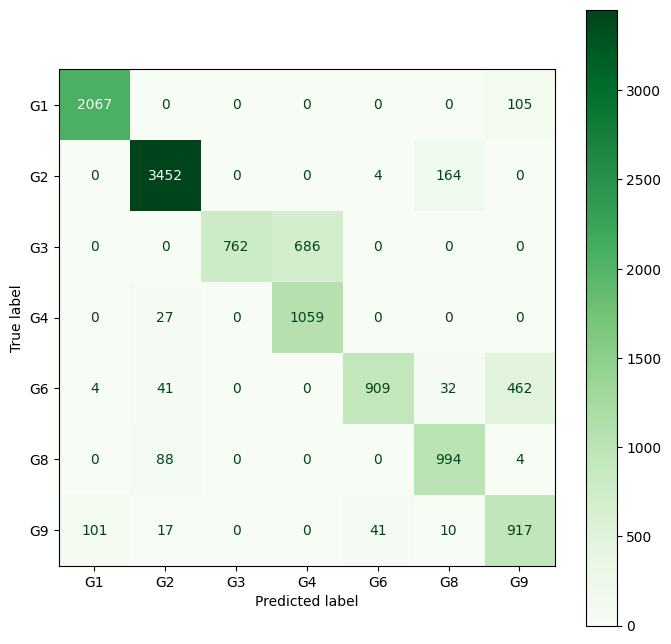

In [26]:
conf_matrix = confusion_matrix(test_trues, test_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['G1', 'G2', 'G3', 'G4', 'G6', 'G8', 'G9'])

fig, ax = plt.subplots(figsize=(8,8))

disp.plot(
    include_values=True,
    cmap="Greens",
    ax=ax,
    xticks_rotation="horizontal",
    values_format="d"
)